In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seisbench.data as sbd
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

/home/namithk/miniconda3/envs/eew/lib/python3.9/site-packages/seisbench/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
dataset = sbd.STEAD()
print("Total samples:", len(dataset))

2026-02-28 12:55:20,604 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


Total samples: 1265657


In [4]:
label_map = {
    "noise": 0,
    "earthquake_local": 1
}

dataset.metadata["label"] = dataset.metadata["trace_category"].map(label_map)

In [5]:
train_indices = dataset.metadata[dataset.metadata["split"] == "train"].index
dev_indices = dataset.metadata[dataset.metadata["split"] == "dev"].index

In [6]:
class SteadTorchDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]

        waveform = self.dataset.get_waveforms([real_idx])[0]
        label = dataset.metadata.iloc[real_idx]["label"]

        waveform = torch.tensor(waveform.copy(), dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return waveform, label

In [7]:
train_dataset = SteadTorchDataset(dataset, train_indices)
dev_dataset = SteadTorchDataset(dataset, dev_indices)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,          # reduce from 64
    shuffle=True,
    num_workers=0           # CRITICAL
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

In [8]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            dilation=dilation
        )

    def forward(self, x):
        x = F.pad(x, (self.padding, 0))
        return self.conv(x)

In [9]:
class CausalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(CausalBlock, self).__init__()

        self.conv = CausalConv1d(in_channels, out_channels, kernel_size, dilation)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

In [10]:
class CausalTCN(nn.Module):
    def __init__(self):
        super(CausalTCN, self).__init__()

        self.block1 = CausalBlock(3, 16, kernel_size=5, dilation=1)
        self.block2 = CausalBlock(16, 32, kernel_size=5, dilation=2)
        self.block3 = CausalBlock(32, 64, kernel_size=5, dilation=4)
        self.block4 = CausalBlock(64, 64, kernel_size=5, dilation=8)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.global_pool(x)
        x = x.squeeze(-1)
        x = self.fc(x)

        return x

In [11]:
model = CausalTCN().to(device)

In [12]:
labels = dataset.metadata.loc[train_indices]["label"].values
classes = np.unique(labels)

weights = compute_class_weight("balanced", classes=classes, y=labels)

pos_weight = torch.tensor([weights[0] / weights[1]]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [17]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [18]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for x, y in loader:
        x = x.to(device)
        y = y.unsqueeze(1).to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [19]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.unsqueeze(1).to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == y).sum().item()
            total += y.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy

In [20]:
num_epochs = 5

best_val_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, dev_loader)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print("-" * 30)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_causal_tcn.pth")
        print("✅ Best model saved!")

Epoch 1
Train Loss: 0.4053
Val Loss: 4.0865
Val Accuracy: 0.4244
------------------------------
✅ Best model saved!
Epoch 2
Train Loss: 0.3987
Val Loss: 1.2365
Val Accuracy: 0.8008
------------------------------
✅ Best model saved!
Epoch 3
Train Loss: 0.3936
Val Loss: 1.3685
Val Accuracy: 0.7590
------------------------------
Epoch 4
Train Loss: 0.3889
Val Loss: 0.9115
Val Accuracy: 0.8670
------------------------------
✅ Best model saved!
Epoch 5
Train Loss: 0.3849
Val Loss: 5.8915
Val Accuracy: 0.5154
------------------------------


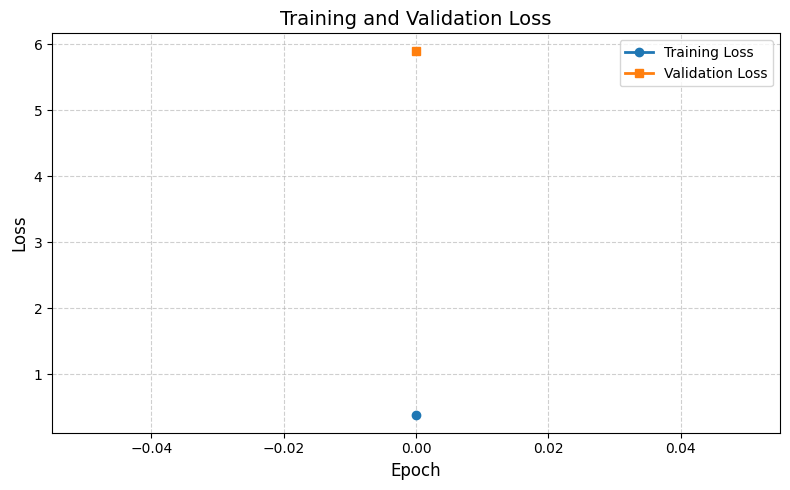

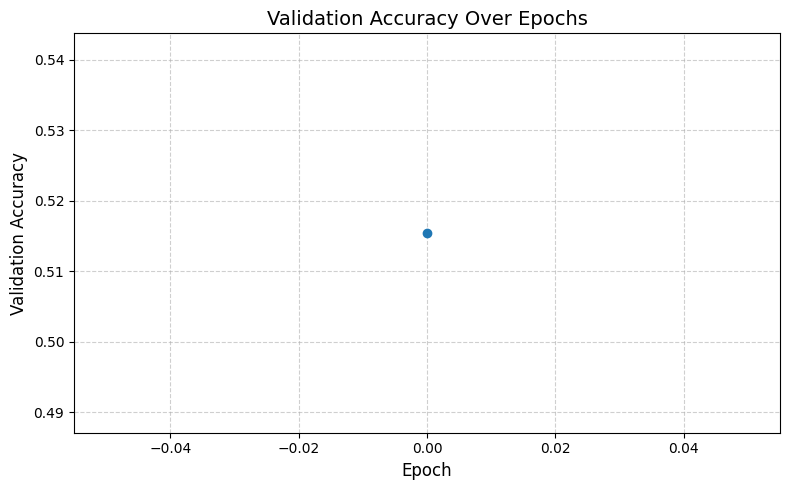

In [21]:
# ================================================================
# FULL TRAINING VISUALIZATION SCRIPT (Publication-Ready Figures)
# ================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report
)

# ------------------------------------------------
# 1️⃣ Plot Training & Validation Loss Curve
# ------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(train_loss, marker='o', linewidth=2, label="Training Loss")
plt.plot(val_loss, marker='s', linewidth=2, label="Validation Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)
plt.show()


# ------------------------------------------------
# 2️⃣ Plot Validation Accuracy Curve
# ------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(val_acc, marker='o', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.title("Validation Accuracy Over Epochs", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("accuracy_curve.png", dpi=300)
plt.show()


# # ------------------------------------------------
# # 3️⃣ ROC Curve + AUC
# # ------------------------------------------------
# fpr, tpr, _ = roc_curve(all_labels, all_probs)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(7,6))
# plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
# plt.plot([0,1], [0,1], linestyle='--')
# plt.xlabel("False Positive Rate", fontsize=12)
# plt.ylabel("True Positive Rate", fontsize=12)
# plt.title("ROC Curve", fontsize=14)
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.savefig("roc_curve.png", dpi=300)
# plt.show()

# print("ROC AUC:", roc_auc)


# # ------------------------------------------------
# # 4️⃣ Precision–Recall Curve + Average Precision
# # ------------------------------------------------
# precision, recall, _ = precision_recall_curve(all_labels, all_probs)
# ap_score = average_precision_score(all_labels, all_probs)

# plt.figure(figsize=(7,6))
# plt.plot(recall, precision, linewidth=2, label=f"AP = {ap_score:.4f}")
# plt.xlabel("Recall", fontsize=12)
# plt.ylabel("Precision", fontsize=12)
# plt.title("Precision-Recall Curve", fontsize=14)
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.savefig("pr_curve.png", dpi=300)
# plt.show()

# print("Average Precision:", ap_score)


# # ------------------------------------------------
# # 5️⃣ Confusion Matrix (Heatmap Style)
# # ------------------------------------------------
# cm = confusion_matrix(all_labels, all_preds)

# plt.figure(figsize=(6,5))
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=["Noise", "Earthquake"],
#     yticklabels=["Noise", "Earthquake"]
# )
# plt.xlabel("Predicted", fontsize=12)
# plt.ylabel("Actual", fontsize=12)
# plt.title("Confusion Matrix", fontsize=14)
# plt.tight_layout()
# plt.savefig("confusion_matrix.png", dpi=300)
# plt.show()


# # ------------------------------------------------
# # 6️⃣ Classification Report (Text Output)
# # ------------------------------------------------
# print("\nClassification Report:\n")
# print(classification_report(all_labels, all_preds, digits=4))

# # ================================================================
# # END OF VISUALIZATION BLOCK
# # ================================================================